In [2]:
import numpy as np

def create_obj_from_asteroid_data(vertices, triangles, output_filename='asteroid.obj'):
    """
    Convert asteroid shape data to OBJ format.
    
    Parameters:
    -----------
    vertices : array-like, shape (N, 3)
        Array of vertex coordinates [x, y, z]
    triangles : array-like, shape (M, 3)
        Array of triangle indices (0-indexed or 1-indexed)
    output_filename : str
        Name of the output OBJ file
    """
    
    vertices = np.array(vertices)
    triangles = np.array(triangles, dtype=int)
    
    # Check if triangles are 0-indexed or 1-indexed
    # OBJ format uses 1-indexed vertices
    if triangles.min() == 0:
        triangles = triangles + 1
    
    with open(output_filename, 'w') as f:
        # Write header
        f.write("# Asteroid shape model\n")
        f.write(f"# Vertices: {len(vertices)}\n")
        f.write(f"# Faces: {len(triangles)}\n\n")
        
        # Write vertices
        for v in vertices:
            f.write(f"v {v[0]:.6f} {v[1]:.6f} {v[2]:.6f}\n")
        
        f.write("\n")
        
        # Write faces
        for t in triangles:
            f.write(f"f {t[0]} {t[1]} {t[2]}\n")
    
    print(f"OBJ file created: {output_filename}")
    print(f"Total vertices: {len(vertices)}")
    print(f"Total faces: {len(triangles)}")


def read_shape_file(filename):
    """
    Read a shape.txt file from lightcurve inversion.
    
    Format:
    - First line: number_of_vertices number_of_facets
    - Next lines: vertex coordinates (x, y, z) - radius vectors in km
    - Following lines: facet vertex indices (0-indexed, anticlockwise)
    """
    vertices = []
    triangles = []
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # First line: number of vertices and facets
    first_line = lines[0].strip().split()
    n_vertices = int(first_line[0])
    n_facets = int(first_line[1])
    
    print(f"Reading {n_vertices} vertices and {n_facets} facets...")
    
    # Read vertices (lines 1 to n_vertices)
    for i in range(1, n_vertices + 1):
        parts = lines[i].strip().split()
        vertices.append([float(parts[0]), float(parts[1]), float(parts[2])])
    
    # Read facets (lines n_vertices+1 to end)
    for i in range(n_vertices + 1, n_vertices + 1 + n_facets):
        parts = lines[i].strip().split()
        # Read all indices in the line (usually 3 for triangles)
        indices = [int(parts[j]) for j in range(len(parts))]
        triangles.append(indices[:3])  # Take first 3 indices for triangle
    
    return np.array(vertices), np.array(triangles)


# Example usage:
if __name__ == "__main__":
    # Method 1: If you have numpy arrays already
    # vertices = np.array([[x1,y1,z1], [x2,y2,z2], ...])
    # triangles = np.array([[v1,v2,v3], [v1,v2,v3], ...])
    # create_obj_from_asteroid_data(vertices, triangles, 'asteroid.obj')
    
    # Method 2: Read from shape.txt file
    vertices, triangles = read_shape_file('model_stdtri.txt')
    create_obj_from_asteroid_data(vertices, triangles, 'model_Torifune.obj')
    
    # # Optional: Add rotation state info as comments
    # rotation_params = {
    #     'lambda': 120.5,  # ecliptic longitude of pole (deg)
    #     'beta': 45.2,     # ecliptic latitude of pole (deg)
    #     'period': 5.27,   # rotation period (hours)
    # }
    
    # # You can append this info to the OBJ file
    # with open('asteroid.obj', 'a') as f:
    #     f.write(f"\n# Rotation state parameters:\n")
    #     for key, val in rotation_params.items():
    #         f.write(f"# {key}: {val}\n")

Reading 1022 vertices and 2040 facets...
OBJ file created: model_Torifune.obj
Total vertices: 1022
Total faces: 2040


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Option 1: Using matplotlib (no extra installation needed)
def visualize_obj_matplotlib(obj_filename):
    """
    Visualize OBJ file using matplotlib.
    Simple and lightweight, good for quick visualization.
    """
    vertices = []
    faces = []
    
    with open(obj_filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif line.startswith('f '):
                parts = line.strip().split()
                # Convert 1-indexed to 0-indexed
                face = [int(parts[i].split('/')[0]) - 1 for i in range(1, 4)]
                faces.append(face)
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the mesh
    mesh = Poly3DCollection(vertices[faces], alpha=0.7, edgecolor='black', linewidth=0.1)
    mesh.set_facecolor('lightblue')
    ax.add_collection3d(mesh)
    
    # Set the aspect ratio and limits
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0
    
    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_title('Asteroid Shape Model')
    
    plt.show()


# Option 2: Using trimesh (need to install: pip install trimesh)
def visualize_obj_trimesh(obj_filename):
    """
    Visualize OBJ file using trimesh.
    More powerful, includes lighting and better rendering.
    """
    import trimesh
    
    # Load the mesh
    mesh = trimesh.load(obj_filename)
    
    # Show the mesh
    mesh.show()
    
    # Optional: Get mesh properties
    print(f"Number of vertices: {len(mesh.vertices)}")
    print(f"Number of faces: {len(mesh.faces)}")
    print(f"Surface area: {mesh.area:.2f} km²")
    print(f"Volume: {mesh.volume:.2f} km³")
    print(f"Center of mass: {mesh.center_mass}")
    
    return mesh


# Option 3: Using PyVista (need to install: pip install pyvista)
def visualize_obj_pyvista(obj_filename):
    """
    Visualize OBJ file using PyVista.
    Professional visualization with interactive controls.
    """
    import pyvista as pv
    
    # Load the mesh
    mesh = pv.read(obj_filename)
    
    # Create a plotter
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='tan', show_edges=True, edge_color='black', 
                     lighting=True, smooth_shading=True)
    
    # Add axes and labels
    plotter.add_axes()
    plotter.show_grid()
    
    # Show the plot
    plotter.show()
    
    return mesh


# Option 4: Using plotly (need to install: pip install plotly)
def visualize_obj_plotly(obj_filename):
    """
    Visualize OBJ file using Plotly.
    Interactive 3D visualization in browser or Jupyter.
    """
    import plotly.graph_objects as go
    
    vertices = []
    faces = []
    
    with open(obj_filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif line.startswith('f '):
                parts = line.strip().split()
                face = [int(parts[i].split('/')[0]) - 1 for i in range(1, 4)]
                faces.append(face)
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Create the mesh3d plot
    fig = go.Figure(data=[
        go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            color='lightblue',
            opacity=0.8,
            flatshading=True
        )
    ])
    
    fig.update_layout(
        title='Asteroid Shape Model',
        scene=dict(
            xaxis_title='X (km)',
            yaxis_title='Y (km)',
            zaxis_title='Z (km)',
            aspectmode='data'
        ),
        width=900,
        height=700
    )
    
    fig.show()


# Main execution
if __name__ == "__main__":
    obj_file = 'model_Torifune.obj'
    
    # Choose your preferred visualization method:
    
    # Method 1: Matplotlib (always available)
    # print("Visualizing with matplotlib...")
    # visualize_obj_matplotlib(obj_file)
    
    # Method 2: Trimesh (uncomment if installed)
    # print("Visualizing with trimesh...")
    # visualize_obj_trimesh(obj_file)
    
    # Method 3: PyVista (uncomment if installed)
    # print("Visualizing with PyVista...")
    # visualize_obj_pyvista(obj_file)
    
    # Method 4: Plotly (uncomment if installed)
    print("Visualizing with Plotly...")
    visualize_obj_plotly(obj_file)

Visualizing with Plotly...


Visualizing with matplotlib...


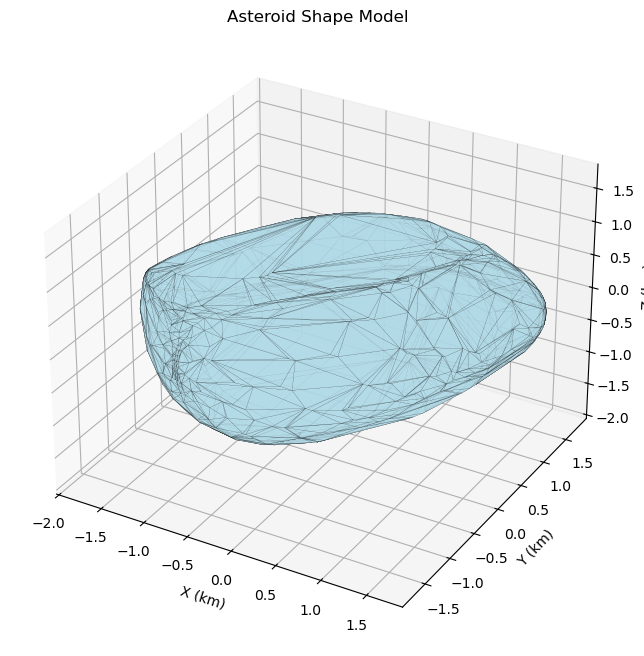

In [2]:
# Main execution
if __name__ == "__main__":
    obj_file = 'model_Torifune.obj'
    
    # Choose your preferred visualization method:
    
    # Method 1: Matplotlib (always available)
    print("Visualizing with matplotlib...")
    visualize_obj_matplotlib(obj_file)
    
    # Method 2: Trimesh (uncomment if installed)
    # print("Visualizing with trimesh...")
    # visualize_obj_trimesh(obj_file)
    
    # Method 3: PyVista (uncomment if installed)
    # print("Visualizing with PyVista...")
    # visualize_obj_pyvista(obj_file)
    
    # Method 4: Plotly (uncomment if installed)
    # print("Visualizing with Plotly...")
    # visualize_obj_plotly(obj_file)

In [13]:
# Main execution
if __name__ == "__main__":
    obj_file = 'model_Torifune.obj'
    
    # Choose your preferred visualization method:
    
    # Method 1: Matplotlib (always available)
    # print("Visualizing with matplotlib...")
    # visualize_obj_matplotlib(obj_file)
    
    # Method 2: Trimesh (uncomment if installed)
    print("Visualizing with trimesh...")
    visualize_obj_trimesh(obj_file)
    
    # Method 3: PyVista (uncomment if installed)
    # print("Visualizing with PyVista...")
    # visualize_obj_pyvista(obj_file)
    
    # Method 4: Plotly (uncomment if installed)
    # print("Visualizing with Plotly...")
    # visualize_obj_plotly(obj_file)

Visualizing with trimesh...
Number of vertices: 1022
Number of faces: 2040
Surface area: 33.32 km²
Volume: 16.10 km³
Center of mass: [ 1.89240837e-08  2.06674807e-09 -5.76122862e-08]


In [3]:
# Main execution
if __name__ == "__main__":
    obj_file = 'model_Torifune.obj'
    
    # Choose your preferred visualization method:
    
    # Method 1: Matplotlib (always available)
    # print("Visualizing with matplotlib...")
    # visualize_obj_matplotlib(obj_file)
    
    # Method 2: Trimesh (uncomment if installed)
    # print("Visualizing with trimesh...")
    # visualize_obj_trimesh(obj_file)
    
    # Method 3: PyVista (uncomment if installed)
    print("Visualizing with PyVista...")
    visualize_obj_pyvista(obj_file)
    
    # Method 4: Plotly (uncomment if installed)
    # print("Visualizing with Plotly...")
    # visualize_obj_plotly(obj_file)

Visualizing with PyVista...


Widget(value='<iframe src="http://localhost:61240/index.html?ui=P_0x203274bfc20_0&reconnect=auto" class="pyvis…